# Working with PySpark logical plan

How to work with spark logical and optimized logical plan to extract useful information.

In [1]:
from quinn.experimental import get_plan_from_df, PlanType, estimate_size_of_df
from quinn.experimental.plan_utils import get_column_lineage, get_column_lineage_graph, plot_column_lineage_graph

/home/sem/github/quinn/quinn/experimental/__init__.py:6: UserWarning: This API is experimental and not stable!
  from quinn.experimental.plan_utils import PlanType # noqa: F401, I001


In [2]:
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.master("local[*]").getOrCreate()

23/12/17 14:58:45 WARN Utils: Your hostname, nixos resolves to a loopback address: 127.0.0.2; using 192.168.0.15 instead (on interface wlp0s20f3)
23/12/17 14:58:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/17 14:58:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data = [(i, f"id{i}", f"id2{i}", f"id3{i}") for i in range(1_100_000)]
sdf = spark.createDataFrame(data, schema="struct<c1:int,c2:string,c3:string,c4:string>").withColumn("new_col", F.col("c1") * 4)

In [4]:
print(get_plan_from_df(sdf, PlanType.PARSED_LOGICAL_PLAN))

'Project [c1#0, c2#1, c3#2, c4#3, ('c1 * 4) AS new_col#8]
+- LogicalRDD [c1#0, c2#1, c3#2, c4#3], false



In [5]:
print(get_plan_from_df(sdf, PlanType.ANALYZED_LOGICAL_PLAN))

Project [c1#0, c2#1, c3#2, c4#3, (c1#0 * 4) AS new_col#8]
+- LogicalRDD [c1#0, c2#1, c3#2, c4#3], false



In [6]:
print(get_plan_from_df(sdf, PlanType.OPTIMIZED_LOGICAL_PLAN))

Project [c1#0, c2#1, c3#2, c4#3, (c1#0 * 4) AS new_col#8]
+- LogicalRDD [c1#0, c2#1, c3#2, c4#3], false



In [7]:
print(get_plan_from_df(sdf, PlanType.PHYSICAL_PLAN))

*(1) Project [c1#0, c2#1, c3#2, c4#3, (c1#0 * 4) AS new_col#8]
+- *(1) Scan ExistingRDD[c1#0,c2#1,c3#2,c4#3]



In [8]:
estimate_size_of_df(sdf) # statistics for generated in runtime DF is not available

-1

For the next few tests we need to work with dataset from the disk. To reproduce the code you can use the `farsante` data generators:
https://github.com/MrPowers/farsante

Especially rust h2o dataset generators:
https://github.com/MrPowers/farsante/tree/master/h2o-data-rust

In [9]:
estimate_size_of_df(spark.read.csv("/home/sem/github/farsante/h2o-data-rust/G1_1e8_1e8_10_5.csv")) # ~4.5 Gb

4831838208.0

Output is in bytes and not so very friendly. By passing an additional parameter `size_in_mb` you can make it more human-readable:

In [10]:
estimate_size_of_df(spark.read.csv("/home/sem/github/farsante/h2o-data-rust/G1_1e8_1e8_10_5.csv"), size_in_mb=True)

4608.0

## Column-level data lineage

There is a special project, that provide more advanced and stable data lineage on the column-level:
https://github.com/AbsaOSS/spline

But `SPLINE` require an additional server and a lot of manual configuration. If you want to have something in-line and lightweight, you can use utilities from `Quinn`.

In [11]:
dat = spark.read.csv("/home/sem/github/farsante/h2o-data-rust/J1_1e8_1e5_5.csv", header=True)

dat.printSchema()

root
 |-- id1: string (nullable = true)
 |-- id2: string (nullable = true)
 |-- id4: string (nullable = true)
 |-- id5: string (nullable = true)
 |-- v2: string (nullable = true)



In [12]:
dat_new = (
    dat.withColumn("id1_renamed", F.col("id1"))
    .withColumn("id1_and_id2", F.concat_ws("_", F.col("id1"), F.col("id2")))
    .withColumn("num1", F.lit(1))
    .withColumn("num2", F.lit(2))
    .select("id1_renamed", "id1_and_id2", "id1", "num1", "num2")
    .withColumn("hash_id", F.hash("id1_and_id2"))
    .join(dat.select("id1", "id4"), on=["id1"], how="left")
    .withColumn("hash_of_two_ids", F.concat_ws("_", "id4", "hash_id"))
    .groupBy("id1_renamed")
    .agg(F.count_distinct("hash_of_two_ids").alias("cnt_ids"), F.sum(F.col("num1") + F.col("num2")).alias("sum_col"))
)

In [13]:
col = "cnt_ids"

In [14]:
lineage = get_column_lineage(dat_new, col)

In [15]:
graph = get_column_lineage_graph(dat_new, col)

/tmp/nix-shell.kUR9Ar/ipykernel_47464/1976561592.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


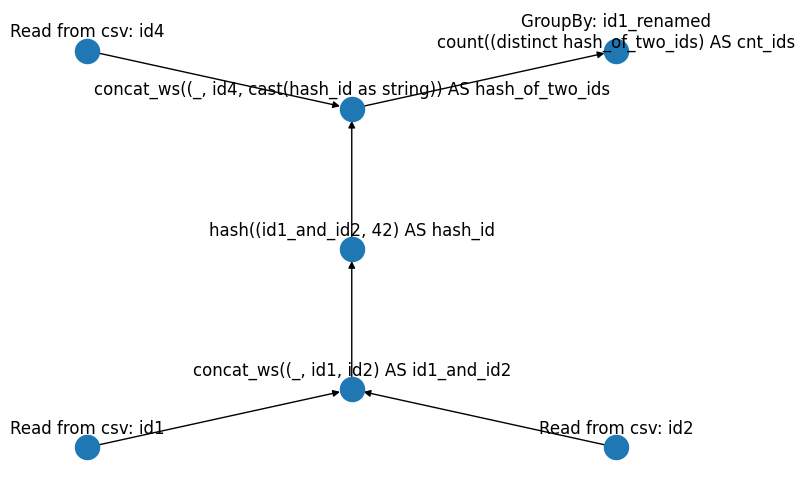

In [16]:
import matplotlib.pyplot as plt
f = plot_column_lineage_graph(dat_new, col)
f.show()